# 5-Fold Cross-Validation with Rotating Test, Validation, and Training Splits

In [9]:
# Install the required packages and import the functions
! pip install -q import-ipynb
! pip install -q scikit-learn
import import_ipynb
from create_pswm import * #function that get the pswm
from validation_and_testing_vonheijne import * #function that creates the validation scores
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

----------------------------------------------------------------------------------------------------
testing set:  1
validation set:  2
training sets:  (3, 4, 5)
MCC = 0.6703593863392895
Precision = 0.9369931378665003
Accuracy = 0.7159763313609467
Sensitivity = 0.6954022988505747
Confusion Matrix : 
          Positive  Negative
Positive      1381        48
Negative        53       121


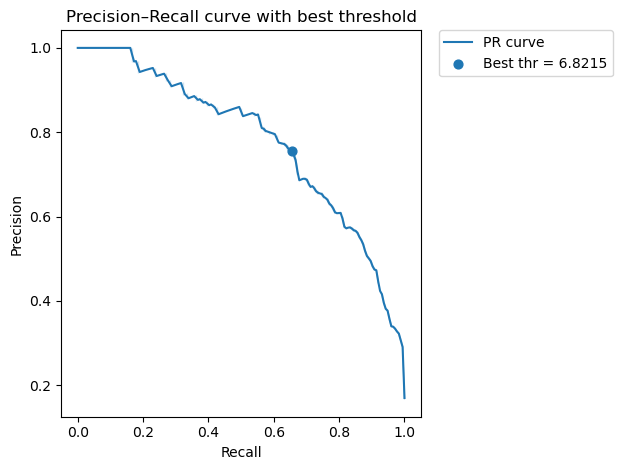

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
testing set:  2
validation set:  3
training sets:  (4, 5, 1)
MCC = 0.6681650954834917
Precision = 0.9351216469120399
Accuracy = 0.6966292134831461
Sensitivity = 0.7126436781609196
Confusion Matrix : 
          Positive  Negative
Positive      1375        54
Negative        50       124


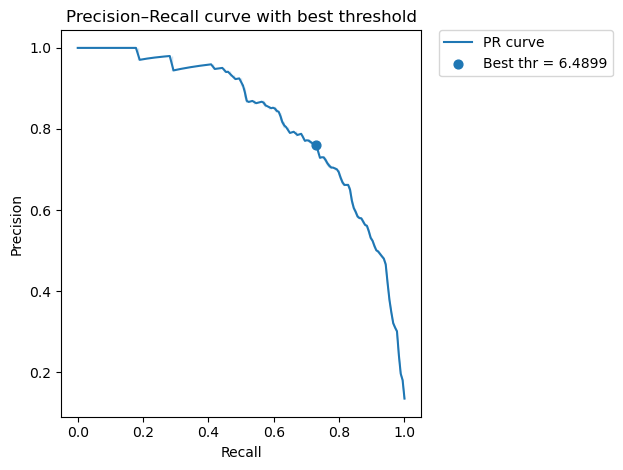

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
testing set:  3
validation set:  4
training sets:  (5, 1, 2)
MCC = 0.7063994537370499
Precision = 0.9413599500935745
Accuracy = 0.7150537634408602
Sensitivity = 0.764367816091954
Confusion Matrix : 
          Positive  Negative
Positive      1376        53
Negative        41       133


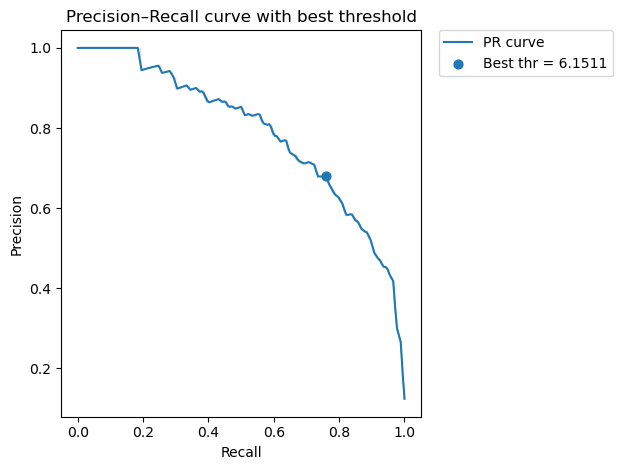

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
testing set:  4
validation set:  5
training sets:  (1, 2, 3)
MCC = 0.6609716473424735
Precision = 0.9276356830941984
Accuracy = 0.638095238095238
Sensitivity = 0.7701149425287356
Confusion Matrix : 
          Positive  Negative
Positive      1353        76
Negative        40       134


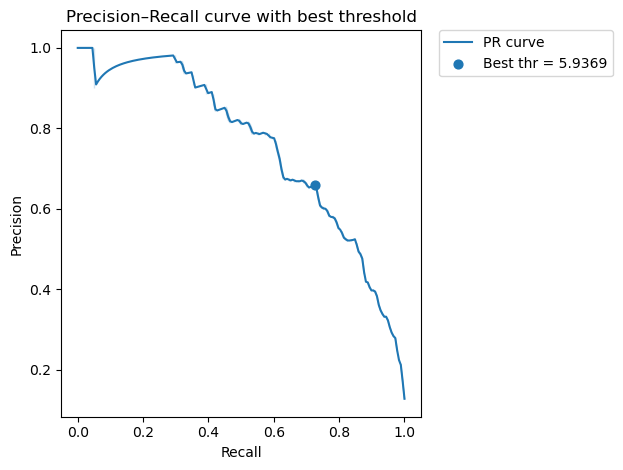

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
testing set:  5
validation set:  1
training sets:  (2, 3, 4)
MCC = 0.6093739445234685
Precision = 0.9266625233064015
Accuracy = 0.689873417721519
Sensitivity = 0.6123595505617978
Confusion Matrix : 
          Positive  Negative
Positive      1382        49
Negative        69       109


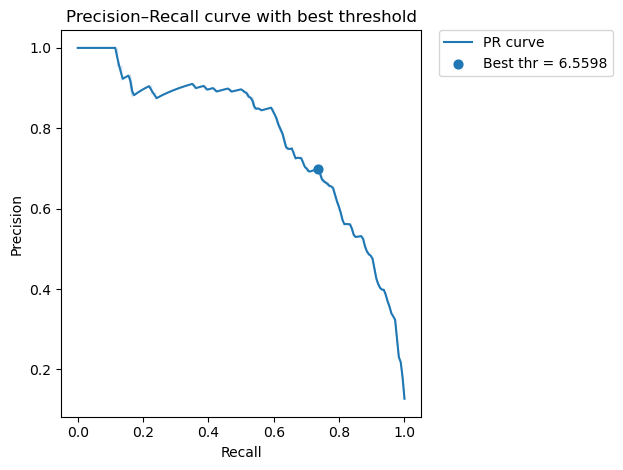

----------------------------------------------------------------------------------------------------














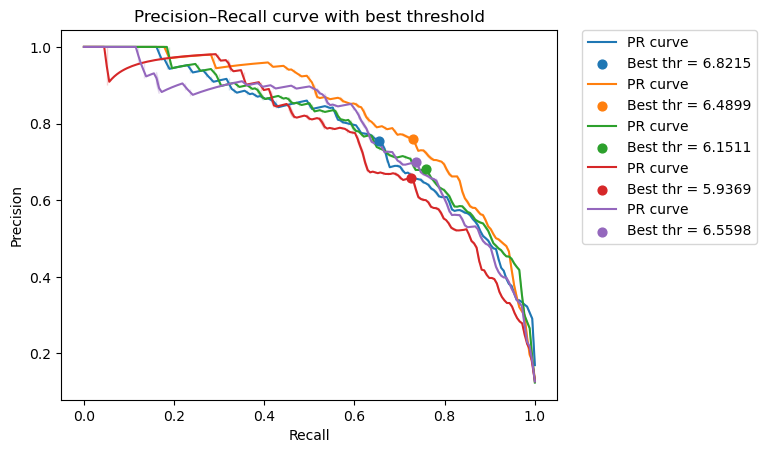

In [10]:
total = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")
stats_list=[]
metrics_name = ["MCC", "Precision", "Accuracy", "Sensitivity" , "Confusion Matrix"]

# 5-cross-validation run: for each run i, testing set=i, validation set=((i)%5)+1, training sets = remaining i sets
for i in range(1,6): 
    
    training_sets=((((i+1)%5)+1),(((i+2)%5)+1),(((i+3)%5)+1)) 
    testing = total.query(f"Set=='{i}'")
    validation = total.query(f"Set=='{((i)%5)+1}'")
    training = total.query(f"Class=='Positive' and (Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")

    print("-"*100)
    print("testing set: ",i)
    print("validation set: ", ((i)%5)+1)
    print("training sets: ",training_sets)

    # Compute the respective iteration PSWM
    pswm=get_pswm(training,13,2)

    # Get the metrics for the i-th run (MCC, Precision, Accuracy, Sensitivity)
    
    stats=metrics(pswm, validation, testing)
    stats_list.append(stats[:-1])
    for name, stat in zip(metrics_name,stats): ####
        if name=="Confusion Matrix":
            confusion_df = pd.DataFrame(stat, columns=["Positive" , "Negative"], index=["Positive", "Negative"])
            print(f"{name} : \n{confusion_df}")
        else:    
            print(f"{name} = {stat}")
        
        
    fig = stats[-1].get_figure()
    fig.tight_layout()

    # display single plots
    display(fig)
    plt.savefig(f"pr_curve_{i}.png" , bbox_inches="tight") 
    plt.close(fig)

    print("-"*100)
    print("\n")  

# Display a single plot with all the Precison-Recall curves and their respectives best thresholds
    
for i in range(1,6): 
    
    training_sets=((((i+1)%5)+1),(((i+2)%5)+1),(((i+3)%5)+1)) 
    testing = total.query(f"Set=='{i}'")
    validation = total.query(f"Set=='{((i)%5)+1}'")
    training = total.query(f"Class=='Positive' and (Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")

    #Compute the respective iteration PSWM
    pswm=get_pswm(training,13,2)

    #Get the metrics for the i-th run (MCC, Precision, Accuracy, Sensitivity)
    stats=metrics(pswm, validation, testing)

    print("\n") 

plt.savefig("all_pr_curves.png" , bbox_inches="tight")   #salva in PNG
plt.show()       

-----------AVERAGED--METRICS-----------


MCC = 0.663 ± 0.016
Precision = 0.934 ± 0.003
Accuracy = 0.691 ± 0.014
Sensitivity = 0.711 ± 0.029


----------------------------------------


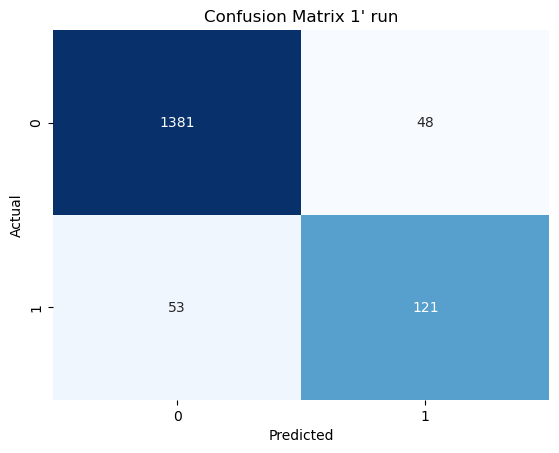

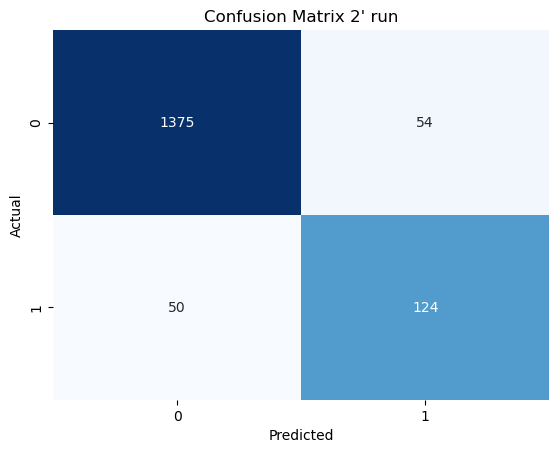

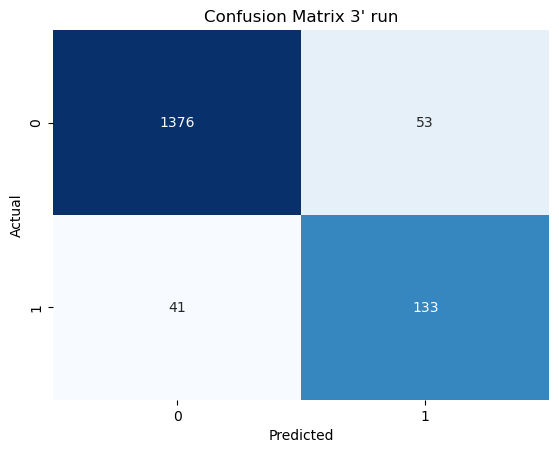

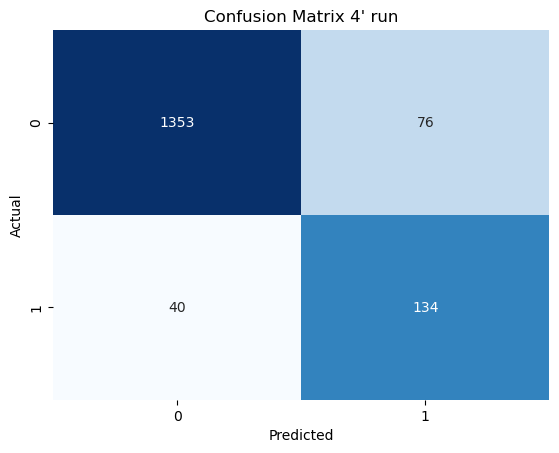

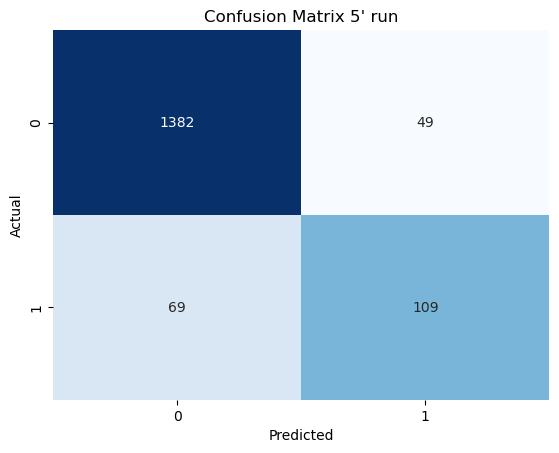

In [11]:
# remove confusion matrices from list of stats to average and put them in another list
stats_clean = [(y1, y2, y3, y4) for (y1, y2, y3, y4, _) in stats_list]   
conf_matrices = [y for (n1, n2, n3, n4, y) in stats_list]  

#Convert the list of stats in an array to facilitate computations
stats_arr = np.array(stats_clean)

#Made the mean of each characteristic (MCC, Precision, Accuracy, Sensitivity)
stats_means = np.mean(stats_arr, axis=0)

#Compute the standard deviation 
stats_stds = stats_arr.std(axis=0, ddof=1)          

#Compute the SE
ses = stats_stds / np.sqrt(stats_arr.shape[0])       

#define the metrics
metrics = ["MCC", "Precision", "Accuracy", "Sensitivity"]

print('-'*11+'AVERAGED--METRICS'+'-'*11)
print("\n")

for name, mean, se in zip(metrics, stats_means, ses):
    print(f"{name} = {mean:.3f} ± {se:.3f}")
    
print("\n")
print('-'*40)

#plot confusion matrices relative to each run:
for i, cm in enumerate(conf_matrices, 1):
    sns.heatmap(
        cm, 
        annot=True, 
        cmap="Blues", 
        fmt="d",
        cbar=False,
        vmax=178)
    plt.title(f"Confusion Matrix {i}' run")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.savefig(f"confusion_matrix_{i}.png" , bbox_inches="tight") 
    plt.show()